引入基本函数库

In [1]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 5.1 MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
from scipy.io import loadmat

定义网络
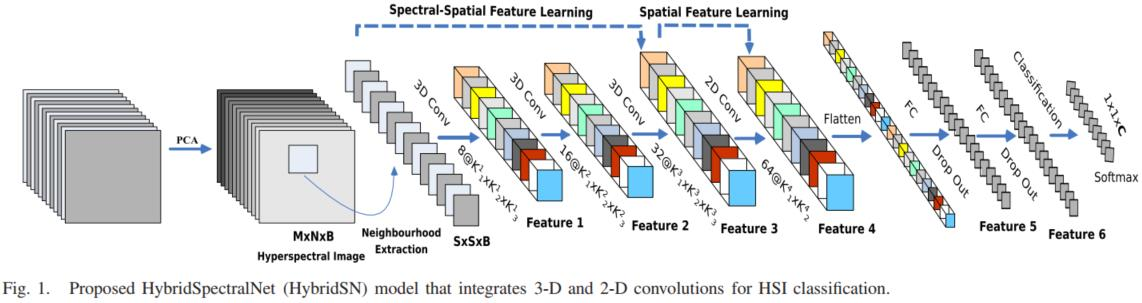

conv1：（1, 30, 25, 25）， 8个 7x3x3 的卷积核 ==>（8, 24, 23, 23） 
conv2：（8, 24, 23, 23）， 16个 5x3x3 的卷积核 ==>（16, 20, 21, 21） 
conv3：（16, 20, 21, 21），32个 3x3x3 的卷积核 ==>（32, 18, 19, 19） 
接下来要进行二维卷积，因此把前面的 32*18 reshape 一下，得到 （576, 19, 19）

二维卷积：（576, 19, 19） 64个 3x3 的卷积核，得到 （64, 17, 17）

接下来是一个 flatten 操作，变为 18496 维的向量，

接下来依次为256，128节点的全连接层，都使用比例为0.4的 Dropout，

最后输出为 16 个节点，是最终的分类类别数。

In [3]:
class_num = 16

class HybridSN(nn.Module):  
  def __init__(self, in_channels=1, out_channels=class_num):
    super(HybridSN, self).__init__()
    self.conv3d_features = nn.Sequential(
        nn.Conv3d(in_channels,out_channels=8,kernel_size=(7,3,3)),
        nn.ReLU(),
        nn.Conv3d(in_channels=8,out_channels=16,kernel_size=(5,3,3)),
        nn.ReLU(),
        nn.Conv3d(in_channels=16,out_channels=32,kernel_size=(3,3,3)),
        nn.ReLU()
    )

    self.conv2d_features = nn.Sequential(
        nn.Conv2d(in_channels=32 * 18, out_channels=64, kernel_size=(3,3)),
        nn.ReLU()
    )

    self.classifier = nn.Sequential(
        nn.Linear(64 * 17 * 17, 256),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(128, 16)
    )
 
  def forward(self, x):
    x = self.conv3d_features(x)
    x = x.view(x.size()[0],x.size()[1]*x.size()[2],x.size()[3],x.size()[4])
    x = self.conv2d_features(x)
    x = x.view(x.size()[0],-1)
    x = self.classifier(x)
    return x

**创建数据集**

首先对高光谱数据实施PCA降维；

然后创建 keras 方便处理的数据格式；

然后随机抽取 10% 数据做为训练集，剩余的做为测试集。


In [4]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

In [5]:
from scipy.io import loadmat
# 地物类别
class_num = 16
X = sio.loadmat('/content/drive/MyDrive/AI data/paviaU/Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('/content/drive/MyDrive/AI data/paviaU/Indian_pines_gt.mat')['indian_pines_gt']

# 用于测试样本的比例
test_ratio = 0.90
# 每个像素周围提取 patch 的尺寸
patch_size = 25
# 使用 PCA 降维，得到主成分的数量
pca_components = 30

print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, numComponents=pca_components)
print('Data shape after PCA: ', X_pca.shape)

print('\n... ... create data cubes ... ...')
X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)
print('Data cube X shape: ', X_pca.shape)
print('Data cube y shape: ', y.shape)

print('\n... ... create train & test data ... ...')
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, test_ratio)
print('Xtrain shape: ', Xtrain.shape)
print('Xtest  shape: ', Xtest.shape)

# 改变 Xtrain, Ytrain 的形状，以符合 keras 的要求
Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
Xtest  = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
print('before transpose: Xtrain shape: ', Xtrain.shape) 
print('before transpose: Xtest  shape: ', Xtest.shape) 

# 为了适应 pytorch 结构，数据要做 transpose
Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
Xtest  = Xtest.transpose(0, 4, 3, 1, 2)
print('after transpose: Xtrain shape: ', Xtrain.shape) 
print('after transpose: Xtest  shape: ', Xtest.shape) 

Hyperspectral data shape:  (145, 145, 200)
Label shape:  (145, 145)

... ... PCA tranformation ... ...
Data shape after PCA:  (145, 145, 30)

... ... create data cubes ... ...
Data cube X shape:  (10249, 25, 25, 30)
Data cube y shape:  (10249,)

... ... create train & test data ... ...
Xtrain shape:  (1024, 25, 25, 30)
Xtest  shape:  (9225, 25, 25, 30)
before transpose: Xtrain shape:  (1024, 25, 25, 30, 1)
before transpose: Xtest  shape:  (9225, 25, 25, 30, 1)
after transpose: Xtrain shape:  (1024, 1, 30, 25, 25)
after transpose: Xtest  shape:  (9225, 1, 30, 25, 25)


In [6]:
class TrainDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
testset  = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=128, shuffle=False, num_workers=2)

开始训练

In [7]:
def train(net):


  current_loss_his = []
  current_Acc_his = []

  best_net_wts = copy.deepcopy(net.state_dict())
  best_acc = 0.0

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  # 开始训练
  total_loss = 0
  for epoch in range(10):
      net.train()  # 将模型设置为训练模式
      for i, (inputs, labels) in enumerate(train_loader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          # 优化器梯度归零
          optimizer.zero_grad()
          # 正向传播 +　反向传播 + 优化 
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      net.eval()   # 将模型设置为验证模式
      current_acc = test_acc(net)
      current_Acc_his.append(current_acc)

      if current_acc > best_acc:
        best_acc = current_acc
        best_net_wts = copy.deepcopy(net.state_dict())

      print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]  [current acc: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item(), current_acc))
      current_loss_his.append(loss.item())

  print('Finished Training')
  print("Best Acc:%.4f" %(best_acc))

  # load best model weights
  net.load_state_dict(best_net_wts)

  return net,current_loss_his,current_Acc_his


In [8]:
def test_acc(net):
  count = 0
  # 模型测试
  for inputs, _ in test_loader:
      inputs = inputs.to(device)
      outputs = net(inputs)
      outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
      if count == 0:
          y_pred_test =  outputs
          count = 1
      else:
          y_pred_test = np.concatenate( (y_pred_test, outputs) )

  # 生成分类报告
  classification = classification_report(ytest, y_pred_test, digits=4)
  index_acc = classification.find('weighted avg')
  accuracy = classification[index_acc+17:index_acc+23]
  return float(accuracy)

In [9]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 网络放到GPU上
net = HybridSN().to(device)
# 训练
net,current_loss_his,current_Acc_his = train(net)

[Epoch: 1]   [loss avg: 22.9688]   [current loss: 2.7423]  [current acc: 0.0574]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 2]   [loss avg: 22.4389]   [current loss: 2.7330]  [current acc: 0.0574]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 3]   [loss avg: 22.1707]   [current loss: 2.6451]  [current acc: 0.0152]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 4]   [loss avg: 21.6380]   [current loss: 2.3276]  [current acc: 0.0574]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 5]   [loss avg: 21.1746]   [current loss: 2.4386]  [current acc: 0.0574]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 6]   [loss avg: 20.8132]   [current loss: 2.2469]  [current acc: 0.0574]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 7]   [loss avg: 20.5450]   [current loss: 2.2804]  [current acc: 0.0574]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 8]   [loss avg: 20.3004]   [current loss: 2.2708]  [current acc: 0.0574]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 9]   [loss avg: 20.0836]   [current loss: 2.2560]  [current acc: 0.0574]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Epoch: 10]   [loss avg: 19.8389]   [current loss: 2.0581]  [current acc: 0.0574]
Finished Training
Best Acc:0.0574


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
print(len(current_loss_his))
current_loss_his

10


[2.7422659397125244,
 2.732994318008423,
 2.645129919052124,
 2.327582597732544,
 2.438617706298828,
 2.246863842010498,
 2.280398368835449,
 2.2708396911621094,
 2.256049394607544,
 2.0580825805664062]

In [11]:
current_Acc_his

[0.0574,
 0.0574,
 0.0152,
 0.0574,
 0.0574,
 0.0574,
 0.0574,
 0.0574,
 0.0574,
 0.0574]

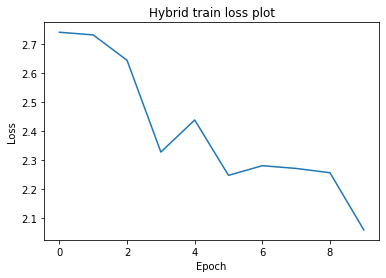

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
def show_plot(data,plot_name,x_name,y_name):#可视化list
  plt.title(plot_name)
  plt.xlabel(x_name)
  plt.ylabel(y_name)
  plt.plot(data)

show_plot(current_loss_his,'Hybrid train loss plot','Epoch','Loss')
#show_plot(current_Acc_his,'Hybrid test acc plot','Epoch','acc')运行两个shaow_plot的话就会在一张图中显示两条曲线

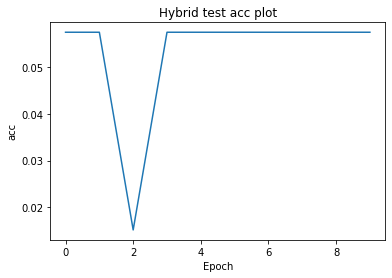

In [13]:
show_plot(current_Acc_his,'Hybrid test acc plot','Epoch','acc')

In [ ]:
net.eval()   # 将模型设置为验证模式
# 测试最好的模型的结果
count = 0
# 模型测试
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
print(ytest[555])
print(y_pred_test.shape)
classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)